#### Lending Club - Statistical Analysis

In [16]:
# load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

In [17]:
sns.set_theme(style="whitegrid")

Reference link for column information [Kaggle Link](https://www.kaggle.com/datasets/adarshsng/lending-club-loan-data-csv)

In [18]:
url = "../../data/lending_data/train_lending_club.csv"

# Loading with optimized dtypes to reduce RAM
df = pd.read_csv(
    url,
    low_memory=True,      # Streaming-type reading to avoid overloading RAM
)


In [19]:
df.head()

,issue_d,sub_grade,term,home_ownership,fico_range_low,total_acc,pub_rec,revol_util,annual_inc,int_rate,...,pub_rec_bankruptcies,addr_state,initial_list_status,fico_range_high,revol_bal,id,open_acc,emp_length,loan_status,time_to_earliest_cr_line
0,2014-01-01,D1,60 months,MORTGAGE,660.0,18.0,0.0,86.8,40440.0,16.99,...,0.0,AR,f,664.0,17264.0,11024793,11.0,2.0,1,478656.0
1,2014-01-01,C4,60 months,MORTGAGE,740.0,26.0,0.0,103.5,59000.0,15.61,...,0.0,VT,f,744.0,6725.0,10596078,8.0,3.0,1,541728.0
2,2014-01-01,A4,36 months,RENT,700.0,47.0,0.0,11.4,40000.0,7.90,...,0.0,TX,w,704.0,7613.0,10775616,27.0,1.0,1,657590.4
3,2014-01-01,D1,60 months,MORTGAGE,665.0,26.0,0.0,56.2,70000.0,16.99,...,0.0,IN,f,669.0,14173.0,10765610,9.0,11.0,1,328838.4
4,2014-01-01,C3,36 months,MORTGAGE,700.0,15.0,1.0,67.1,120000.0,14.98,...,0.0,LA,f,704.0,2549.0,10794837,8.0,2.0,1,305164.8


In [20]:
df.columns

Index(['issue_d', 'sub_grade', 'term', 'home_ownership', 'fico_range_low',
       'total_acc', 'pub_rec', 'revol_util', 'annual_inc', 'int_rate', 'dti',
       'purpose', 'mort_acc', 'loan_amnt', 'application_type', 'installment',
       'verification_status', 'pub_rec_bankruptcies', 'addr_state',
       'initial_list_status', 'fico_range_high', 'revol_bal', 'id', 'open_acc',
       'emp_length', 'loan_status', 'time_to_earliest_cr_line'],
      dtype='object')

## Business Question & Answers

#### What fraction of loans end up defaulted, by loan-amount bucket (small / medium / large)?

In [21]:
dfq = df.loc[:, ['loan_amnt', 'loan_status']]
dfq.head()

,loan_amnt,loan_status
0,17775.0,1
1,29175.0,1
2,6000.0,1
3,15600.0,1
4,10000.0,1


In [22]:
dfq.describe()

,loan_amnt,loan_status
count,236846.000000,236846.000000
mean,14626.430888,0.831591
std,8611.590744,0.374230
min,1000.000000,0.000000
25%,8000.000000,1.000000
50%,12450.000000,1.000000
75%,20000.000000,1.000000
max,40000.000000,1.000000


In [23]:
q33 = np.percentile(dfq['loan_amnt'], 33.34, interpolation="midpoint")
q66 = np.percentile(dfq['loan_amnt'], 66.67, interpolation="midpoint")

print(f"33.34% percentile: {q33}, 66.67% percentile: {q66}")

33.34% percentile: 10000.0, 66.67% percentile: 17000.0


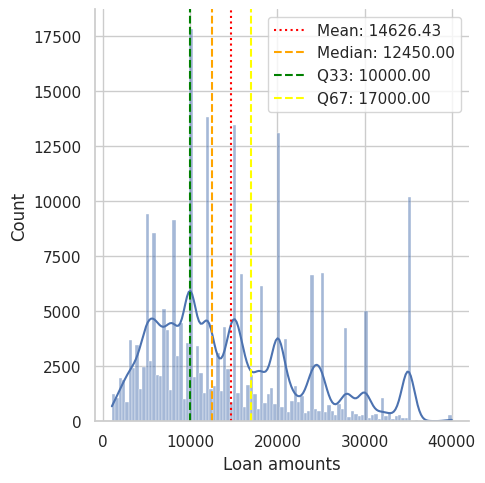

In [24]:
mean = np.mean(dfq['loan_amnt'])
median = np.median(dfq['loan_amnt'])

sns.displot(
    dfq,
    x="loan_amnt",
    kde=True
)
plt.axvline(mean, color="red", linestyle=":", label=f"Mean: {mean:.2f}")
plt.axvline(median, color="orange", linestyle="--", label=f"Median: {median:.2f}")
plt.axvline(q33, color="green", linestyle="--", label=f"Q33: {q33:.2f}")
plt.axvline(q66, color="yellow", linestyle="--", label=f"Q67: {q66:.2f}")
plt.legend()
plt.xlabel("Loan amounts")
plt.show()

Creating buckets based on Q33 & Q67

In [25]:
loan_bucket_conditions = [
    (dfq['loan_amnt'] <= q33), 
    (dfq['loan_amnt'] > q33) & (dfq['loan_amnt'] <= q66),
    (dfq['loan_amnt'] > q66) & (dfq['loan_amnt'] <= np.max(dfq['loan_amnt']))
]

loan_bucket_names = [
    'Small',
    'Medium',
    'Large'
]

dfq['loan_bucket'] = np.select(loan_bucket_conditions, loan_bucket_names, default="Unknown")
dfq.head()

,loan_amnt,loan_status,loan_bucket
0,17775.0,1,Large
1,29175.0,1,Large
2,6000.0,1,Small
3,15600.0,1,Medium
4,10000.0,1,Small


In [26]:
bucket_fraction_defaulter = pd.Series(dfq.query('loan_status == 0')['loan_bucket'].value_counts(), name="defaulter")
bucket_fraction_all = pd.Series(dfq['loan_bucket'].value_counts(), name="all")
print(bucket_fraction_defaulter / bucket_fraction_all * 100)

loan_bucket
Large     20.640157
Medium    19.226869
Small     12.052297
dtype: float64


In [27]:
loan_defaulter_df = pd.concat([bucket_fraction_defaulter, bucket_fraction_all], axis=1).reset_index()
loan_defaulter_df['fraction'] = loan_defaulter_df['defaulter'] / loan_defaulter_df['all']
loan_defaulter_df

,loan_bucket,defaulter,all,fraction
0,Large,16205,78512,0.206402
1,Medium,12325,64103,0.192269
2,Small,11357,94231,0.120523


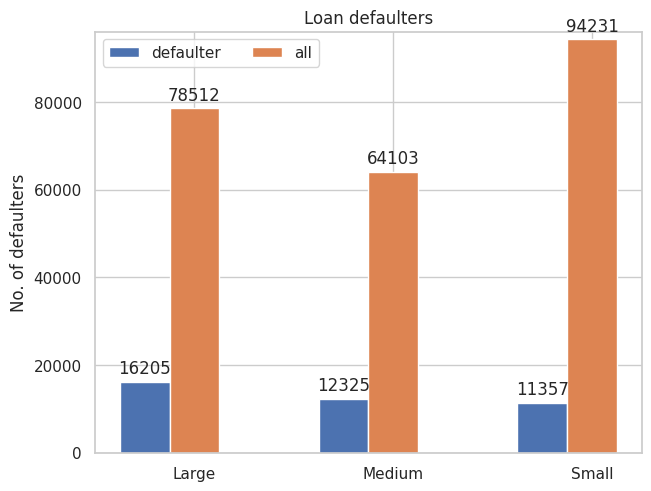

In [28]:
x = np.arange(len(loan_defaulter_df))
loan_defaulter_df_v = loan_defaulter_df.drop(columns=['fraction', 'loan_bucket'])
width = 0.25  # the width of the bars
multiplier = 0
fig, ax = plt.subplots(layout='constrained')
for attr, metrics in loan_defaulter_df_v.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, metrics, width, label=attr)
    ax.bar_label(rects, padding=3)
    multiplier += 1

ax.set_ylabel('No. of defaulters')
ax.set_title('Loan defaulters')
ax.set_xticks(x + width, loan_defaulter_df['loan_bucket'])
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 96000)
plt.show()

In [30]:
# q1 = 33rd percentile, q2 = 66th percentile
q1, q2 = df["loan_amnt"].quantile([0.33, 0.66])

def bucketize(x):
    if x <= q1:
        return "Small"
    elif x <= q2:
        return "Medium"
    return "Large"

df["bucket"] = df["loan_amnt"].apply(bucketize)

In [33]:
df

,issue_d,sub_grade,term,home_ownership,fico_range_low,total_acc,pub_rec,revol_util,annual_inc,int_rate,...,addr_state,initial_list_status,fico_range_high,revol_bal,id,open_acc,emp_length,loan_status,time_to_earliest_cr_line,bucket
0,2014-01-01,D1,60 months,MORTGAGE,660.0,18.0,0.0,86.8,40440.0,16.99,...,AR,f,664.0,17264.0,11024793,11.0,2.0,1,478656.0,Large
1,2014-01-01,C4,60 months,MORTGAGE,740.0,26.0,0.0,103.5,59000.0,15.61,...,VT,f,744.0,6725.0,10596078,8.0,3.0,1,541728.0,Large
2,2014-01-01,A4,36 months,RENT,700.0,47.0,0.0,11.4,40000.0,7.90,...,TX,w,704.0,7613.0,10775616,27.0,1.0,1,657590.4,Small
3,2014-01-01,D1,60 months,MORTGAGE,665.0,26.0,0.0,56.2,70000.0,16.99,...,IN,f,669.0,14173.0,10765610,9.0,11.0,1,328838.4,Medium
4,2014-01-01,C3,36 months,MORTGAGE,700.0,15.0,1.0,67.1,120000.0,14.98,...,LA,f,704.0,2549.0,10794837,8.0,2.0,1,305164.8,Small
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236841,2015-12-01,C2,36 months,RENT,675.0,33.0,0.0,93.3,85000.0,12.59,...,FL,w,679.0,23969.0,67476992,27.0,0.0,0,276220.8,Large
236842,2015-08-01,D2,36 months,MORTGAGE,665.0,15.0,0.0,17.8,72000.0,16.55,...,NJ,f,669.0,7918.0,56130981,8.0,11.0,0,533779.2,Medium
236843,2016-02-01,B1,36 months,MORTGAGE,710.0,19.0,0.0,61.2,72000.0,8.39,...,FL,w,714.0,16029.0,71502396,10.0,11.0,0,376185.6,Small
236844,2016-06-01,C3,60 months,RENT,675.0,23.0,1.0,40.1,67000.0,13.99,...,MN,f,679.0,8422.0,83875883,10.0,11.0,1,867801.6,Medium


In [32]:
# -----------------------------------------------------------
# 3. DEFAULT FRACTION PER BUCKET
# -----------------------------------------------------------
default_rate = df.groupby("bucket")["loan_status"].mean()
default_rate

bucket
Large     0.794526
Medium    0.806950
Small     0.879477
Name: loan_status, dtype: float64

In [36]:
contingency = pd.crosstab(df['bucket'], df['loan_status'])

# Ensure it always has columns 0 and 1 (even if dataset is imbalanced)
for status in [0, 1]:
    if status not in contingency.columns:
        contingency[status] = 0

contingency = contingency[[0, 1]]  # enforce column order

contingency

loan_status,0,1
bucket,,
Large,16508,63833
Medium,12022,50252
Small,11357,82874


In [37]:
# -----------------------------------------------------------
# 5. CHI-SQUARE TEST
# -----------------------------------------------------------
chi2, p_value, dof, expected = chi2_contingency(contingency)

# -----------------------------------------------------------
# 6. PRINT RESULTS
# -----------------------------------------------------------
print("\nDefault Rate by Loan Bucket:")
print(default_rate)

print("\nContingency Table (Bucket x Default):")
print(contingency)

print("\nChi-Square Test:")
print("Chi2 Statistic:", chi2)
print("p-value:", p_value)
print("Degrees of Freedom:", dof)
print("\nExpected Counts:")
print(pd.DataFrame(expected, index=contingency.index, columns=contingency.columns))


Default Rate by Loan Bucket:
bucket
Large     0.794526
Medium    0.806950
Small     0.879477
Name: loan_status, dtype: float64

Contingency Table (Bucket x Default):
loan_status      0      1
bucket                   
Large        16508  63833
Medium       12022  50252
Small        11357  82874

Chi-Square Test:
Chi2 Statistic: 2601.00998554353
p-value: 0.0
Degrees of Freedom: 2

Expected Counts:
loan_status             0             1
bucket                                 
Large        13530.148143  66810.851857
Medium       10487.502588  51786.497412
Small        15869.349269  78361.650731


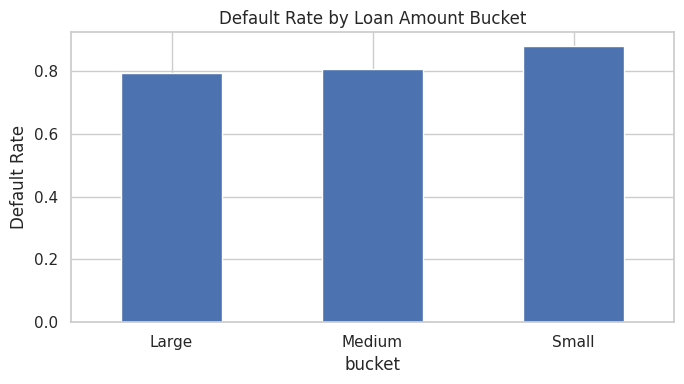

In [38]:
plt.figure(figsize=(7, 4))
default_rate.plot(kind="bar")
plt.ylabel("Default Rate")
plt.title("Default Rate by Loan Amount Bucket")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()